<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/TFNormal_Abnormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Neural Network - Normal and Abnormal

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow import keras
from PIL import Image

print(tf.__version__)

2.4.0


In [ ]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import cv2

## Preparing the Data

In [ ]:
filenames = os.listdir("/projects/sc73/ranzcr-clip-catheter-line-classification/train")

In [ ]:
#Subsetting the data
train_data = pd.read_csv("/projects/sc73/ranzcr-clip-catheter-line-classification/train.csv")
train_data

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30078,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,1,0,5b5b9ac30
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d
30081,1.2.826.0.1.3680043.8.498.95092491950130838685...,0,0,0,0,0,0,0,0,1,0,0,01a6602b8


In [ ]:
#extracting just the CVC labels, and just Normal and Abnormal catheters
CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Normal"]]
CVC_train.set_index('StudyInstanceUID', inplace=True)
CVC_train = CVC_train.drop(CVC_train[(CVC_train["CVC - Abnormal"] == 0) & (CVC_train["CVC - Normal"] == 0)].index)
CVC_train.drop("CVC - Abnormal", axis = 'columns', inplace = True)
CVC_train["CVC - Normal"].sum()

21324

In [ ]:
CVC_normal = CVC_train[CVC_train["CVC - Normal"] == 1].sample(n = 2000)
CVC_abnormal = CVC_train[CVC_train["CVC - Normal"] == 0].sample(n = 2000)
CVC_all = pd.concat([CVC_normal, CVC_abnormal])
CVC_all

,CVC - Normal
StudyInstanceUID,
1.2.826.0.1.3680043.8.498.83944916333526123502778490500928788639,1
1.2.826.0.1.3680043.8.498.23933321106006088567170276662551480315,1
1.2.826.0.1.3680043.8.498.84400982664153368598738672971053132124,1
1.2.826.0.1.3680043.8.498.59376680813742484063095010151880137373,1
1.2.826.0.1.3680043.8.498.91751632618204442295160422886897847632,1
...,...
1.2.826.0.1.3680043.8.498.83097595799508746778446434996490113777,0
1.2.826.0.1.3680043.8.498.11333894316143324337529593966002928477,0
1.2.826.0.1.3680043.8.498.19229796633151935648327076303774354430,0


In [ ]:
len(CVC_all)

4000

In [ ]:
CVC_train = CVC_all

In [ ]:
from PIL import Image
size = 600
train_imgs = np.empty((0,size, size))
FileIDs = []
lst = []

count = 0
for file in filenames:
  if count == 300:
    break

  #only importing the image if the image is part of the subsetted data
  if file.replace(".jpg","") in CVC_train.index:

    #Making sure the images are the same pixel size
    img = Image.open(f"/projects/sc73/ranzcr-clip-catheter-line-classification/train/{file}")
    img = img.resize((size,size))
    img = np.array(img)

    #add extra dimension so we can concatenate
    img = np.expand_dims(img,(0))

    #Save filename for later
    FileIDs.append(file)

    #adding to train_imgs array
    train_imgs = np.concatenate((train_imgs, img), axis = 0)

    count += 1

In [ ]:
#cleaning up the labels
UID = []
for ID in FileIDs:
    ID = ID.replace(".jpg","")
    if ID in CVC_train.index:
        UID.append(ID)

In [ ]:
data = []
for ID in UID:
    data.append(CVC_train.loc[ID])

train_labels_df = pd.DataFrame(data)

train_labels_df = train_labels_df.reindex(UID)

train_labels = train_labels_df.values
train_labels_df

,CVC - Normal
1.2.826.0.1.3680043.8.498.20829430711461815077247364797774896990,0
1.2.826.0.1.3680043.8.498.35072888985370991799652296889578661624,0
1.2.826.0.1.3680043.8.498.10724541644358274215523122873926253955,1
1.2.826.0.1.3680043.8.498.12271878036664828678891914784344423473,0
1.2.826.0.1.3680043.8.498.81820017770914828024018162370001439126,1
...,...
1.2.826.0.1.3680043.8.498.33496817214155111186732586634241228007,1
1.2.826.0.1.3680043.8.498.76794125332716608263154717912129536285,1
1.2.826.0.1.3680043.8.498.10533863396518656580245826580989141214,0
1.2.826.0.1.3680043.8.498.46691559386432145944373733448410137409,0


In [ ]:
from sklearn.model_selection import train_test_split

normalized_images = train_imgs / 255.0  # Normalising the pixel of the images

X = normalized_images
Y = train_labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ANNOTATED DATA

In [ ]:
anno_df = pd.read_csv("/projects/sc73/ranzcr-clip-catheter-line-classification/train_annotations.csv")
anno_df = anno_df[(anno_df['label'] == 'CVC - Normal') | (anno_df['label'] == 'CVC - Abnormal')]
anno_df["label"] = anno_df["label"].replace({"CVC - Normal": 1, "CVC - Abnormal": 0})
anno_normal = anno_df[anno_df["label"] == 1].sample(n = 350)
anno_abnormal = anno_df[anno_df["label"] == 0].sample(n = 350)
anno_df = pd.concat([anno_normal, anno_abnormal])
anno_df = anno_df.reset_index(drop=True)
anno_df

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.37784761397507321564...,1,"[[921, 901], [936, 860], [955, 836], [980, 815..."
1,1.2.826.0.1.3680043.8.498.99639605094624784905...,1,"[[2583, 1090], [2532, 1026], [2462, 957], [236..."
2,1.2.826.0.1.3680043.8.498.48805713281949763010...,1,"[[734, 1077], [727, 589], [712, 353], [648, 18..."
3,1.2.826.0.1.3680043.8.498.25755803986279453282...,1,"[[936, 871], [991, 710], [1111, 576], [1274, 4..."
4,1.2.826.0.1.3680043.8.498.13054605655150115189...,1,"[[1282, 966], [1291, 855], [1312, 745], [1343,..."
...,...,...,...
695,1.2.826.0.1.3680043.8.498.22420917910405243013...,0,"[[935, 769], [958, 784], [1002, 801], [1045, 8..."
696,1.2.826.0.1.3680043.8.498.80694113169580785316...,0,"[[1682, 1288], [1721, 1119], [1724, 940], [169..."
697,1.2.826.0.1.3680043.8.498.98695105155776417580...,0,"[[339, 629], [391, 699], [457, 768], [546, 827..."
698,1.2.826.0.1.3680043.8.498.76647715259188312737...,0,"[[998, 1217], [1002, 1144], [1007, 1035], [102..."


In [ ]:
def _parse_annotation(raw):
    annotation = ast.literal_eval(raw)
    annotation = np.array(annotation, dtype=np.int32)
    annotation = np.expand_dims(annotation, axis=0)
    return annotation

def scale_annotations(annotation, original_shape, target_shape):
    ratio_y = target_shape[0] / original_shape[0]
    ratio_x = target_shape[1] / original_shape[1]
    annotation_scaled = [[int(xratio_x), int(yratio_y)] for [x, y] in annotation]
    return annotation_scaled

def annotate(img, target, annotation):
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    original_shape = img.shape[:2]
    annotation = _parse_annotation(annotation)
    annotation = annotation[0]
    # annotation = scale_annotations(annotation, original_shape, (256, 256))
    # print(annotation)
    img = cv2.polylines(img, [np.array(annotation)], False, color=(255, 0, 0), thickness=20)
    return img

In [ ]:
from torch.utils.data import Dataset
import ast
import torch

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, anno_df):
        self.anno_df = anno_df
        self.anno_file_names = anno_df["StudyInstanceUID"].values
        self.labels = anno_df['label'].values

    def __len__(self):
        return len(self.anno_df)

    def __getitem__(self, idx):
        file_name = self.anno_file_names[idx]
        image_path = f"/projects/sc73/ranzcr-clip-catheter-line-classification/train/{file_name}.jpg"

        image = cv2.imread(image_path)
        image = annotate(image, self.anno_df["label"][idx], self.anno_df["data"][idx])
        image = cv2.resize(image, (360,360))
        image = np.asarray(image, dtype=np.float32) / 255.0

        labels = self.labels[idx]
        return image, labels

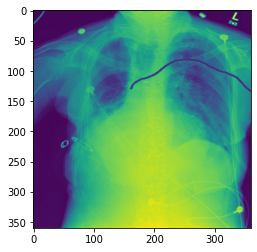

In [ ]:
train_data = CustomDataset(anno_df)
gray_image = cv2.cvtColor(train_data[0][0], cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)

In [ ]:
size = 360
train_imgs = np.empty((0,size, size))
train_labels = []

for i in range(len(train_data)):
    train_data = CustomDataset(anno_df)
    img, label = train_data[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img,(0))
    train_imgs = np.concatenate((train_imgs, img), axis = 0)
    train_labels.append(label)

    # plt.imshow(train_data[0], cmap=plt.cm.binary)

In [ ]:
train_labels = np.array(train_labels)
train_imgs.shape

(700, 360, 360)

In [ ]:
from sklearn.model_selection import train_test_split

X = train_imgs
Y = train_labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Making and training the model

In [ ]:
def get_allignment(labels):
    if labels == 1:
        return "Normal"
    else:
        return "Abnormal"

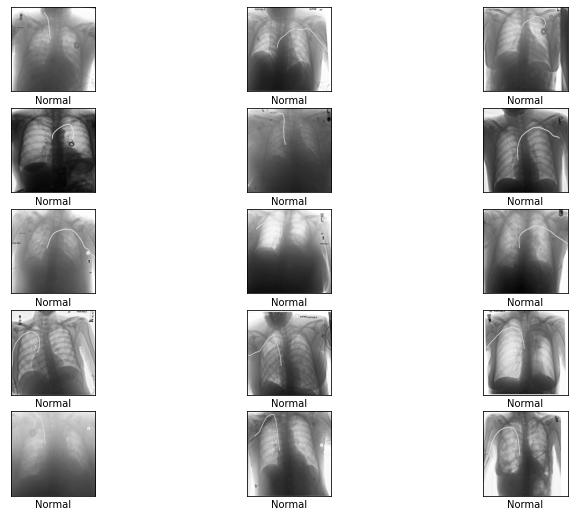

In [ ]:
#displaying 6 of the images in the train_imgs array
plt.figure(figsize=(12,9))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_imgs[i+20], cmap=plt.cm.binary)
    plt.xlabel(get_allignment(train_labels[i+20]))
plt.show()

In [ ]:
lr = 0.01
epochs=70
img_size = (size, size)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=img_size),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
    ])

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

opt = keras.optimizers.Adam(learning_rate=lr)
# opt = SGD(learning_rate= lr)
reducelr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr = 0.0001)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data = (X_test, Y_test), callbacks=[reducelr_cb])

Epoch 1/70
18/18 [==============================] - 2s 94ms/step - loss: 346.1730 - accuracy: 0.5010 - val_loss: 33.0406 - val_accuracy: 0.4357
Epoch 2/70
18/18 [==============================] - 1s 65ms/step - loss: 25.3426 - accuracy: 0.4724 - val_loss: 7.1236 - val_accuracy: 0.5643
Epoch 3/70
18/18 [==============================] - 1s 71ms/step - loss: 14.5813 - accuracy: 0.4815 - val_loss: 4.3148 - val_accuracy: 0.5643
Epoch 4/70
18/18 [==============================] - 1s 68ms/step - loss: 2.8024 - accuracy: 0.5233 - val_loss: 4.8029 - val_accuracy: 0.4357
Epoch 5/70
18/18 [==============================] - 1s 70ms/step - loss: 2.9123 - accuracy: 0.5126 - val_loss: 0.7723 - val_accuracy: 0.5929
Epoch 6/70
18/18 [==============================] - 1s 66ms/step - loss: 0.8152 - accuracy: 0.5729 - val_loss: 0.7851 - val_accuracy: 0.6071
Epoch 7/70
18/18 [==============================] - 1s 66ms/step - loss: 0.7059 - accuracy: 0.6035 - val_loss: 0.7351 - val_accuracy: 0.4643
Epoch 8/

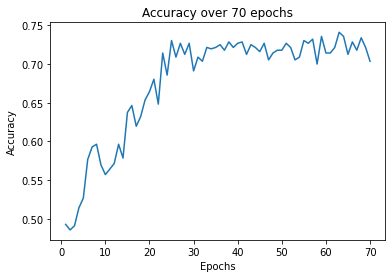

In [ ]:
plt.plot(range(1,epochs+1), history.history["accuracy"])
plt.title(f"Accuracy over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

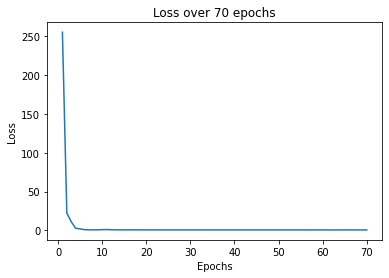

In [ ]:
plt.plot(range(1,epochs+1), history.history["loss"])
plt.title(f"Loss over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss");


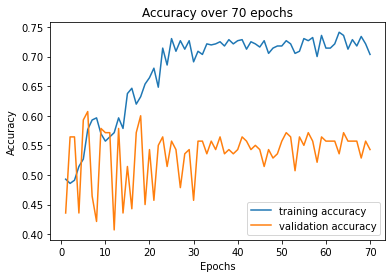

In [ ]:
plt.plot(range(1,epochs+1), history.history["accuracy"])
plt.plot(range(1,epochs+1), history.history["val_accuracy"])
plt.legend(['training accuracy', 'validation accuracy'])
plt.title(f"Accuracy over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
plt.plot(range(1,epochs+1), history.history["loss"])
plt.plot(range(1,epochs+1), history.history["val_loss"])
plt.legend(['training loss', 'validation loss'])
plt.title(f"Loss over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss");

Text(0.5, 0, 'Abnormal')

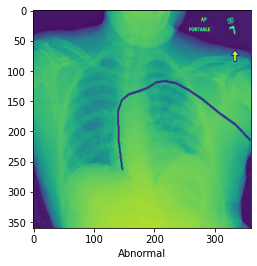

In [ ]:
test_index = 9
plt.imshow(X_test[test_index])
plt.xlabel(get_allignment(Y_test[test_index]))

In [ ]:
# probability_model = tf.keras.Sequential([model,
#                                          tf.keras.layers.Softmax()])

In [ ]:
test = np.expand_dims(X_test[test_index],(0))
test.shape

(1, 360, 360)

In [ ]:
test_result = model.predict(test)
test_result[0][0]

0.2762719

In [ ]:
test_labels = ["Normal", "Abnormal"]

Text(0.5, 1.0, 'Model Prediction')

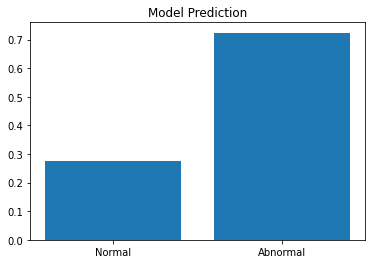

In [ ]:
plt.bar(test_labels, [test_result[0][0], 1 -test_result[0][0]])
plt.title("Model Prediction")

.